In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data, DataLoader

from tqdm import tqdm
import glob

from src.model import SAGE_model, GraphTrainer
from src.graph import build_grid_graph, plot_grid_graph

In [2]:
PATH_HIST_DATA  = "/Users/grigorii/Desktop/SCUC/SCUS_warm_start/data/case14/*case14*.npz"
PATH_GRID = "/Users/grigorii/Desktop/SCUC/SCUS_warm_start/data/grids/case14.json" 

# Power flow on each transmission line does not exceed its thermal limits
LIMIT = 300.0 
THRESH  = 0.98 * LIMIT

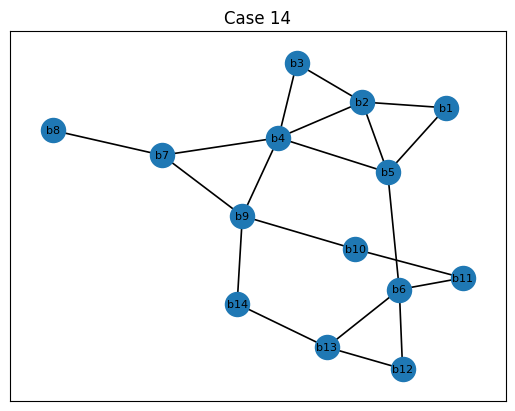

In [3]:
# Create and plot a graph from the grid data
G, bus_idx, edges_order, edge_attr_static = build_grid_graph(PATH_GRID, LIMIT)

plot_grid_graph(G, bus_idx)

In [4]:
# TODO: ADD HISTORICAL FLOW IN DATASET
def approx_max_flow(loads, X_vec):
    res = []
    for (u, v), X in zip(G.edges, X_vec):
        diff = np.abs(loads[u] - loads[v]) / X
        res.append(diff.max())
    return np.array(res)


# Statistic data for topology
records = []

edge_index = torch.tensor(list(G.edges)).t().contiguous()  

for day_f in tqdm(sorted(glob.glob(PATH_HIST_DATA))):
    arr = np.load(day_f)
    loads = arr["loads"].reshape(len(bus_idx), -1)
    commit = arr["commit"]
    
    # Features
    max_f = approx_max_flow(loads, edge_attr_static[:,0])
    y = (max_f >= THRESH).astype(int)
    peak = loads.sum(0).max()
    mean = loads.sum(0).mean()
    dyn = np.column_stack([np.full(len(G.edges), peak / LIMIT), np.full(len(G.edges), mean / LIMIT)])
    
    x_np = np.concatenate([edge_attr_static, dyn], axis=1)
    x = torch.tensor(x_np, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.float32)
    
    records.append(Data(x=x, edge_index=edge_index, y=y_t))
    
print(f"Collected {len(records)} graphs")

100%|██████████| 365/365 [00:00<00:00, 2066.36it/s]

Collected 365 graphs


In [5]:
# DATASET
n_total = len(records)
n_train = int(0.8 * n_total)

train_set = records[:n_train]
val_set   = records[n_train:]

loader_train = DataLoader(train_set, batch_size=16, shuffle=True)
loader_val = DataLoader(val_set, batch_size=16)

/Users/grigorii/Library/Python/3.9/lib/python/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


# ML model

In [6]:
if torch.backends.mps.is_available():
    DEVICE = "mps"
elif torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

print(f"Using device: {DEVICE}")

model = SAGE_model(records[0].x.size(1)).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
bce_loss = nn.BCELoss()
EPOCHS = 100

trainer = GraphTrainer(
    model=model,
    optimizer=optimizer,
    criterion=bce_loss,
    loader_train=loader_train,
    loader_val=loader_val,
    epochs = EPOCHS,
    device   = DEVICE
)

trainer.fit()

Using device: mps
Epoch 000 | loss=3.9400 | recall_binding=0.000
Epoch 001 | loss=1.0943 | recall_binding=0.000
Epoch 002 | loss=0.4550 | recall_binding=0.000
Epoch 003 | loss=0.3589 | recall_binding=0.000
Epoch 004 | loss=0.3390 | recall_binding=0.000
Epoch 005 | loss=0.3280 | recall_binding=0.000
Epoch 006 | loss=0.3198 | recall_binding=0.000
Epoch 007 | loss=0.3150 | recall_binding=0.000
Epoch 008 | loss=0.3027 | recall_binding=0.000
Epoch 009 | loss=0.2947 | recall_binding=0.000
Epoch 010 | loss=0.2867 | recall_binding=0.000
Epoch 011 | loss=0.2776 | recall_binding=0.000
Epoch 012 | loss=0.2674 | recall_binding=0.000
Epoch 013 | loss=0.2590 | recall_binding=0.000
Epoch 014 | loss=0.2539 | recall_binding=0.000
Epoch 015 | loss=0.2484 | recall_binding=0.000
Epoch 016 | loss=0.2384 | recall_binding=0.000
Epoch 017 | loss=0.2339 | recall_binding=0.000
Epoch 018 | loss=0.2249 | recall_binding=0.000
Epoch 019 | loss=0.2231 | recall_binding=0.000
Epoch 020 | loss=0.2164 | recall_binding=0